## Planejamento da solução (IOT)

### Input - Entrada

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
    
2. Conjunto de dados
    - Vendas de um e-comerce online, durante o período de um ano

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider
                10254  | yes
                88347  | no
                
2. Relatório com as respostas das pergumtas de negócio

    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    
    - Quantos clientes farão parte do grupo?
    
    - Quais as principais características desses clientes ?
    
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    
    - Quais as condições para uma pessoa ser removida do Insiders ?
    
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto ticket médio.
        - Alto LTV.
        - Baixa recência.
        - Alto basket size.
        - Baixa probabilidade de churn.
        - Alta previsão LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiencia de compra:
        - Média alta de avaliação
        

2. Quantos clientes farão parte do grupo?
    - Número total de clientes;
    - % do grupo Insiders
    

3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        - Idade;
        - Localização;
        - País;
        
    - Escrever caracteristicas do consumo:
        - Atributos da clusterização


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano;
    - Faturamento do grupo Insiders;


5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
     - LTV do grupo Insiders;
     - Análise de Cohort;
     - Séries temporais (ARIMA, HoltWinter);


6. Quais as condições para uma pessoa ser elegível ao Insiders ?
     - Definir a periodicidade (1 mês, 3 mêses);
     - A pessoa precsa ser similar ou parecido com uma pessoa do grupo
     

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mês, 3 mêses);
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto;
    - Preferencia de compra;
    - Produtos exclusivos

# 0.0 Imports

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
from matplotlib          import pyplot as plt
from IPython.display     import HTML
from sklearn             import cluster as c
from sklearn import metrics as m
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [3]:
df_raw = pd.read_csv('data/Ecommerce.csv')

In [4]:
# droping extra column
df_raw.drop(columns=['Unnamed: 8'], axis=1, inplace=True)

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [6]:
df1.columns = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']

## 1.2 Data Dimensions

In [7]:
df1.shape

(541909, 8)

## 1.3 Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check Na

In [9]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace Na

In [10]:
# remove na
df1.dropna(subset=['description','customer_id'], inplace=True)

## 1.6 Change Types

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive Statistics 

# 2.0 Feature Engineering

In [12]:
df2 = df1.copy()

## 2.1 Feature Creation

In [13]:
df_ref = df2.drop(['invoice_no','stock_code','description','quantity',
                   'invoice_date','unit_price','country'], axis=1).drop_duplicates(ignore_index=True)

In [14]:
# Gross Revenue (Faturamento)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - last day purchase
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg ticket
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')

# 3.0 Variable Filtering

In [15]:
df3 = df_ref.copy()

# 4.0  EDA

In [16]:
df4 = df3.copy()

# 5.0 Data Preparation

In [17]:
df5 = df4.copy()

# 6.0 Feature Selection

In [18]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine_Tunning

In [19]:
X = df6.drop(columns=['customer_id'])

In [20]:
clusters = [2,3,4,5,6,7]

## 7.1 Within Cluster Sum of Square (WSS)

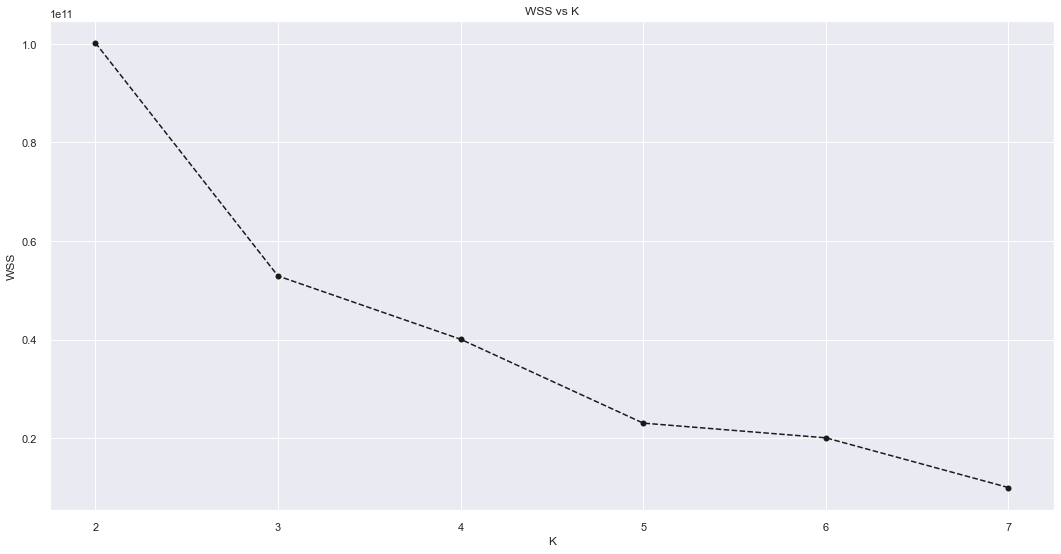

In [21]:
wss = []

for k in clusters:
    # model definiton
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )
    
    # model training
    kmeans.fit(X)
    
    # validation
    wss.append(kmeans.inertia_)
    
# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='k')
plt.xlabel('K');
plt.ylabel('WSS');
plt.title('WSS vs K');

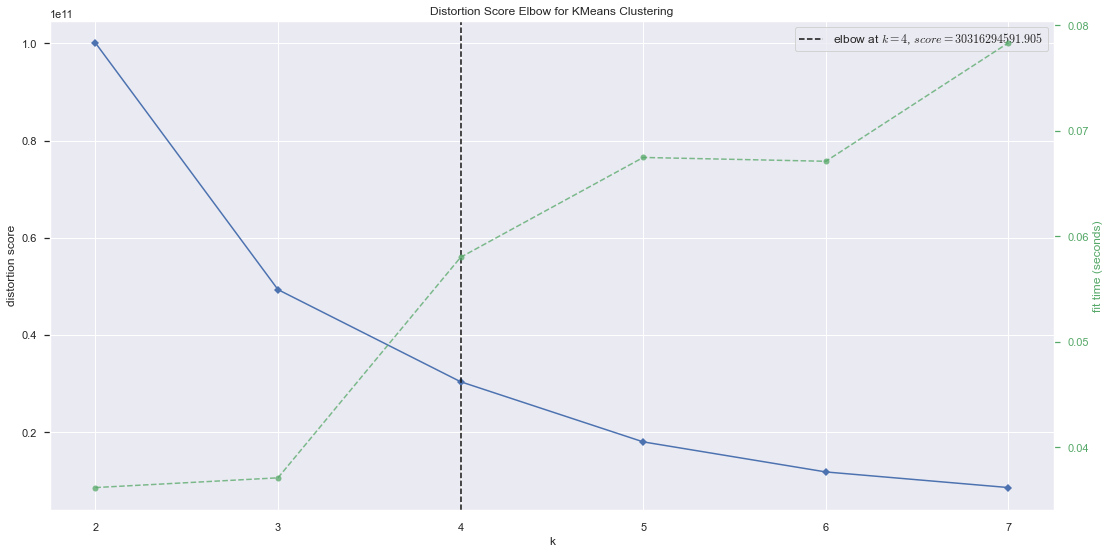

In [22]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

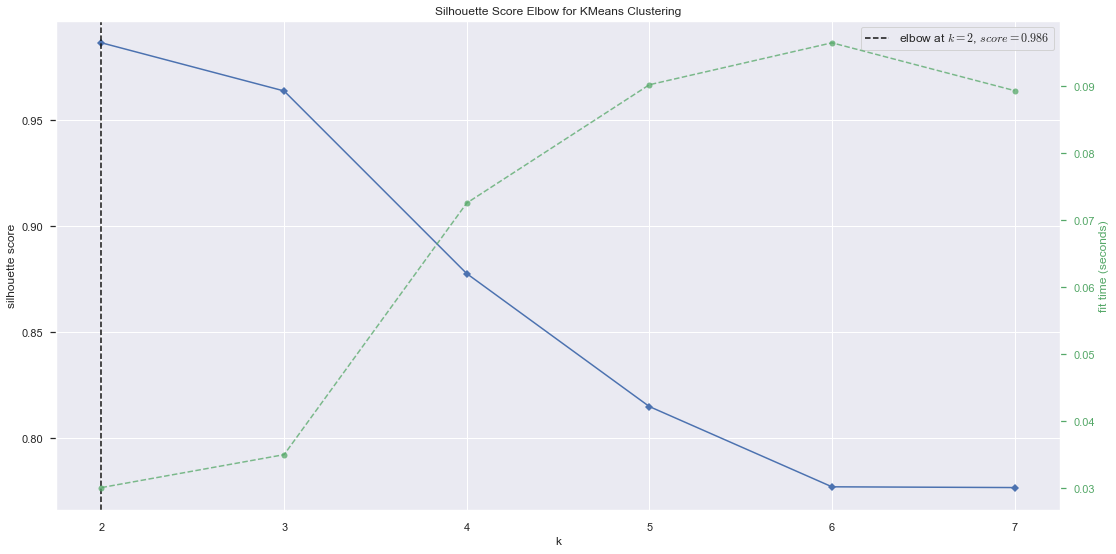

In [23]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timing=False)
kmeans.fit(X)
kmeans.show();

## 7.3 Silhouette Analysis

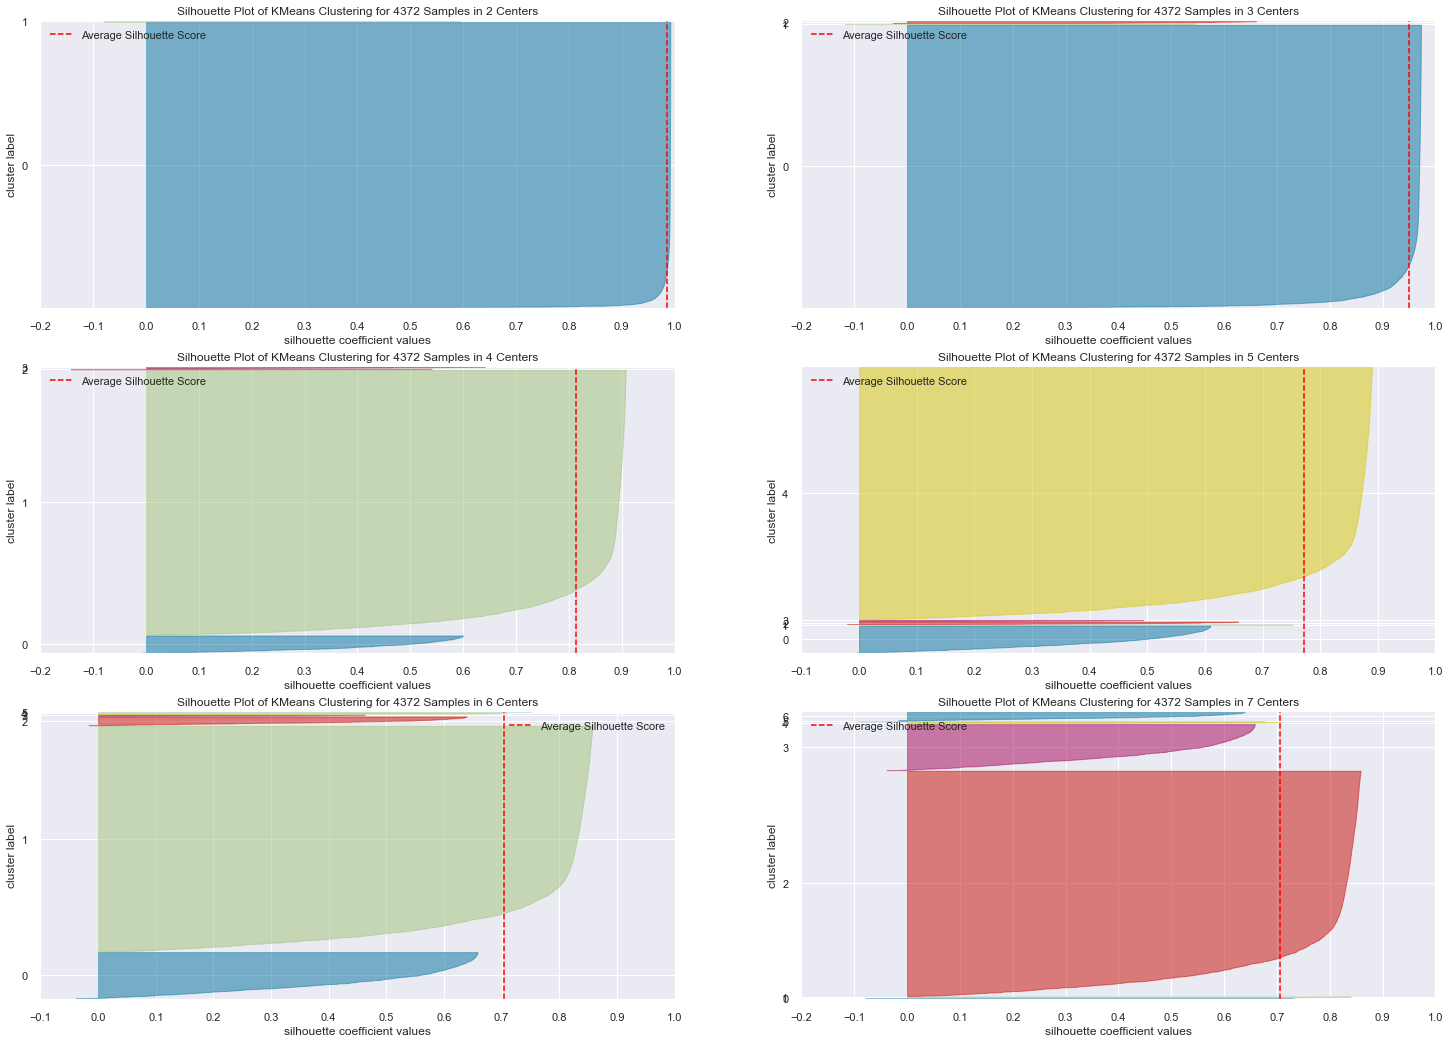

In [24]:
fig,ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [25]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model traiing
kmeans.fit(X)

# clustering
labels =kmeans.labels_

## 8.2 Cluster Validation

In [26]:
## WSS (Within cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 40056254626.30003
SS value: 0.8139972028952442


# 9.0 Cluster Analysis

In [27]:
df9 = df6.copy()

df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.95,0
1,13047,3079.10,31,18,15.71,2
2,12583,7187.34,2,18,28.63,0
3,13748,948.25,95,5,33.87,2
4,15100,635.10,330,6,105.85,2


## 9.1 Visualization Inspection

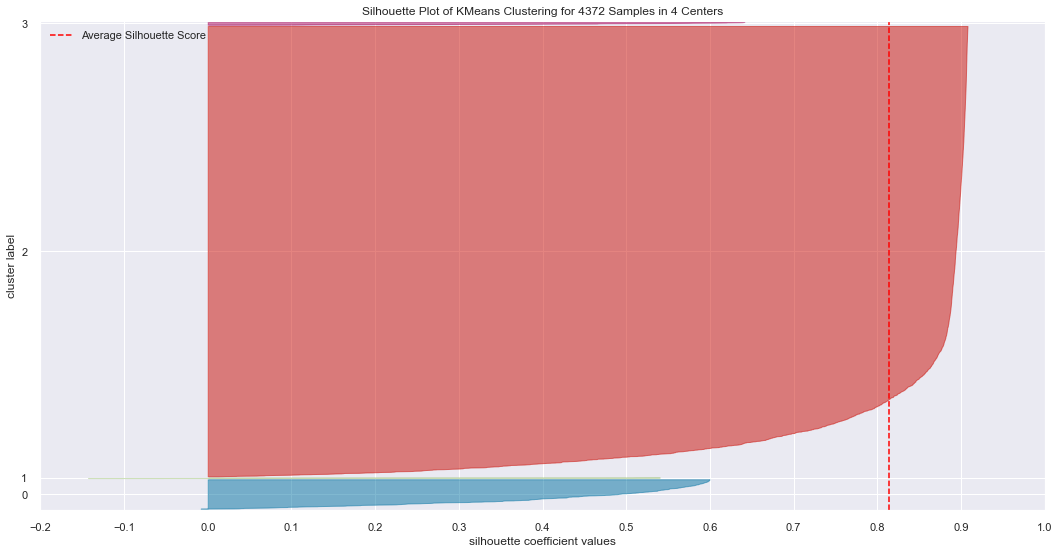

In [28]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d Plot

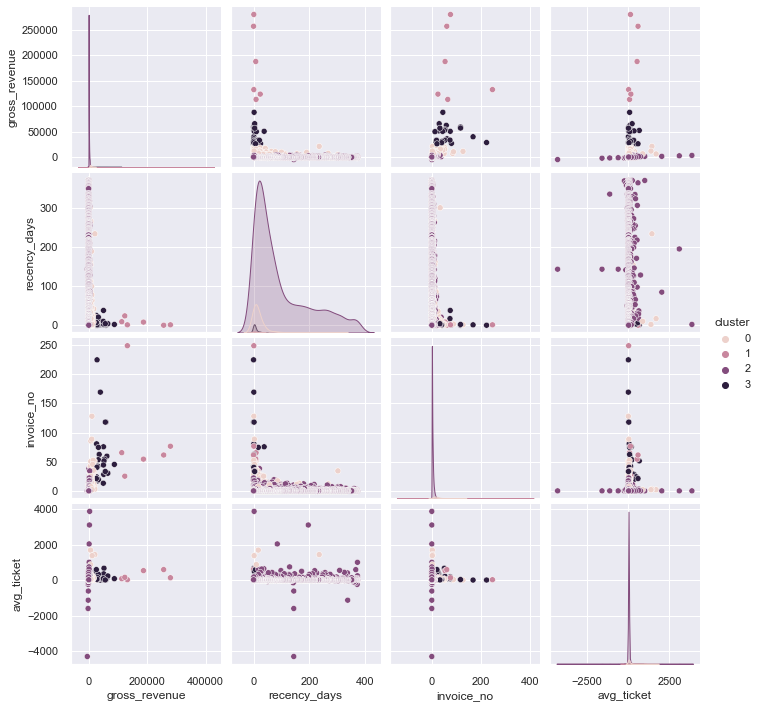

In [29]:
df_viz = df9.drop('customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [30]:
import umap.umap_ as umap

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

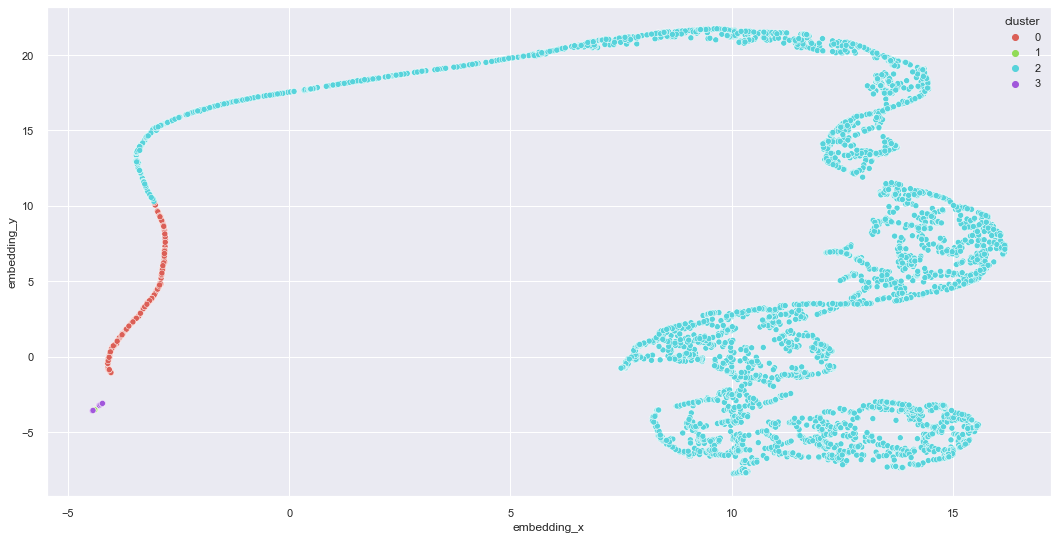

In [36]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y', hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), 
                data=df_viz)

## 9.4 Cluster Profile

In [39]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

#Avg ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner',on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,267,6.11,8089.03,20.28,19.53,62.78
1,1,6,0.14,182181.98,7.17,89.00,253.63
2,2,4071,93.12,946.70,96.97,3.64,25.36
3,3,28,0.64,42614.39,6.18,57.82,162.86


In [33]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,267,6.11,8089.03,20.28,19.53
1,1,6,0.14,182181.98,7.17,89.00
2,2,4071,93.12,946.70,96.97,3.64
3,3,28,0.64,42614.39,6.18,57.82


### Cluster 01: (Candidato a insiders)
- Número de customers: 6 (0.14% do customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00

### Cluster 02:
- Número de customers: 31 (0.71% do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:
- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# 10.0 Deploy